# Tutorial: Brd4 bindings for Male/Female mouse bulk calling cards data. 

These are brd4 bulk calling cards datasets for the glioblastoma(GBM) in mice brains of both female and male from [Kfoury et al., PNAS. (2021)](https://www.pnas.org/doi/10.1073/pnas.2017148118), and it can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156821).
 
 In this tutorial, we will call peaks, make annotation, do differential peak analysis, and pair bindings with gene expression. There are 668525 insertions in female qbed data and 613728 insertions in male qbed data. For bulk RNA-seq data, there are 6 samples in total: 3 female samples and 3 male samples.

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc

We start by reading qbed data. In this data, one row is one insertion and the columns indicate the chromosome, start point and end point, reads number, the direction and barcode of each insertion. For example, the first row means one insertion is on Chromosome 1, and it starts from 3478112 and endes on 3478115. The reads number is 1 with the direction going from 3' to 5'. The barcode of the cell is TTTGTCCAA. We add another column indecating its respected group. 

Use ```cc.rd.read_qbed(filename)``` to load your own qbed data.

In [2]:
Female_Brd4 = cc.datasets.mouse_brd4_data(data="Female_Brd4")
Female_Brd4['group'] = "Female_Brd4"
Female_Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3478111,3478115,1,+,TTTGTCCAA,Female_Brd4
1,chr1,3481743,3481747,1,+,TATGTACAA,Female_Brd4
2,chr1,3481957,3481961,1,-,TATGTACAA,Female_Brd4
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
4,chr1,3493702,3493706,1,+,CGTTACACA,Female_Brd4
...,...,...,...,...,...,...,...
1290214,chrY,90802841,90802845,1,-,CGTTACACA,Female_Brd4
1290215,chrY,90803579,90803583,1,-,TATGTACAA,Female_Brd4
1290216,chrY,90803579,90803583,1,-,TGTCGTGCA,Female_Brd4
1290217,chrY,90804429,90804433,1,-,TATACTCTA,Female_Brd4


In [3]:
Male_Brd4 = cc.datasets.mouse_brd4_data(data="Male_Brd4")
Male_Brd4['group'] = "Male_Brd4"
Male_Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3493161,3493165,1,-,GAGGTACAG,Male_Brd4
1,chr1,3493275,3493279,1,+,TACTTTCCG,Male_Brd4
2,chr1,3493341,3493345,2,+,AGCACAGTG,Male_Brd4
3,chr1,3493341,3493345,10,+,TGTCCATTG,Male_Brd4
4,chr1,3493341,3493345,8,+,ATGAAAGCA,Male_Brd4
...,...,...,...,...,...,...,...
1185697,chrY,90803733,90803737,13,-,TACTTTCCG,Male_Brd4
1185698,chrY,90803733,90803737,9,-,CACGGCGGA,Male_Brd4
1185699,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4
1185700,chrY,90803774,90803778,4,-,ATGAAAGCA,Male_Brd4


Combine the two datasets to call peaks together.

In [4]:
Brd4 = cc.rd.combine_qbed([Female_Brd4,Male_Brd4])
Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3478111,3478115,1,+,TTTGTCCAA,Female_Brd4
1,chr1,3481743,3481747,1,+,TATGTACAA,Female_Brd4
2,chr1,3481957,3481961,1,-,TATGTACAA,Female_Brd4
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
4,chr1,3493161,3493165,1,-,GAGGTACAG,Male_Brd4
...,...,...,...,...,...,...,...
2475916,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4
2475917,chrY,90803774,90803778,4,-,ATGAAAGCA,Male_Brd4
2475918,chrY,90804429,90804433,1,-,TATACTCTA,Female_Brd4
2475919,chrY,90805130,90805134,1,-,GACGGCTCC,Female_Brd4


Filter the insertions with reads greater than 2.

In [5]:
Brd4 = Brd4[Brd4['Reads']>2]
Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
7,chr1,3493341,3493345,10,+,TGTCCATTG,Male_Brd4
8,chr1,3493341,3493345,8,+,ATGAAAGCA,Male_Brd4
10,chr1,3493643,3493647,3,+,TCTACTGCC,Male_Brd4
17,chr1,3514553,3514557,7,+,TACTTTCCG,Male_Brd4
...,...,...,...,...,...,...,...
2475905,chrY,42512546,42512550,3,-,ACGCGCTGT,Male_Brd4
2475914,chrY,90803733,90803737,13,-,TACTTTCCG,Male_Brd4
2475915,chrY,90803733,90803737,9,-,CACGGCGGA,Male_Brd4
2475916,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4


Because insertions are discrete, we now need to call peaks to deduce potential binding sites. Three different methods (*CCcaller, cc_tools, Blockify*) are available along with three different species (*hg38, mm10, yeast*). 

In this setting, we use ***CCcaller*** in *mouse*('mm10') data. *maxbetween* is the most important parameter for *CCcaller*. It controls the maximum distance between two nearby insertions, or in another words, the minimum distance between two peaks. 800-2500 is a good parameter for *maxbetween*.  *pvalue_cutoff* is also an important parameter, and a number below 0.05 is strongly advised.

In [6]:
peak_data = cc.pp.call_peaks(Brd4, method = "CCcaller", reference = "mm10", pvalue_cutoff = 0.01, maxbetween = 1100,
                   lam_win_size = 1000000,  pseudocounts = 0.1, record = True, save = "peak.bed")
peak_data

For the CCcaller method without background, [expdata, reference, pvalue_cutoff, fdr_cutoff, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue,pvalue_adj
0,chr1,4196775,4198714,16,12,0.142389,0.000000e+00,0.000000e+00
1,chr1,4785068,4786551,17,15,0.572576,0.000000e+00,0.000000e+00
2,chr1,4806673,4807730,21,12,0.477937,0.000000e+00,0.000000e+00
3,chr1,4856928,4862019,104,44,1.490080,0.000000e+00,0.000000e+00
4,chr1,4912814,4916593,7,22,0.791756,1.900897e-06,1.024407e-04
...,...,...,...,...,...,...,...,...
25996,chrX,169936677,169937745,7,8,1.189526,3.479200e-05,1.673495e-03
25997,chrY,897430,899700,11,24,0.528165,6.046275e-13,5.162843e-11
25998,chrY,1009018,1011799,27,25,0.489073,0.000000e+00,0.000000e+00
25999,chrY,1243715,1246316,24,29,0.504932,0.000000e+00,0.000000e+00



In order to choose suitable a method and parameters for peak calling, please take a look at genome areas. We stongly advise to adjust the parameters for ```cc.pp.callpeaks()``` to call better peaks.

In this plot, the top section is insertions and their read counts. One dot is an insertion and the height is log(reads+1). The middle section is the distribution of insertions. The bottom section represents the reference genes and peaks. 

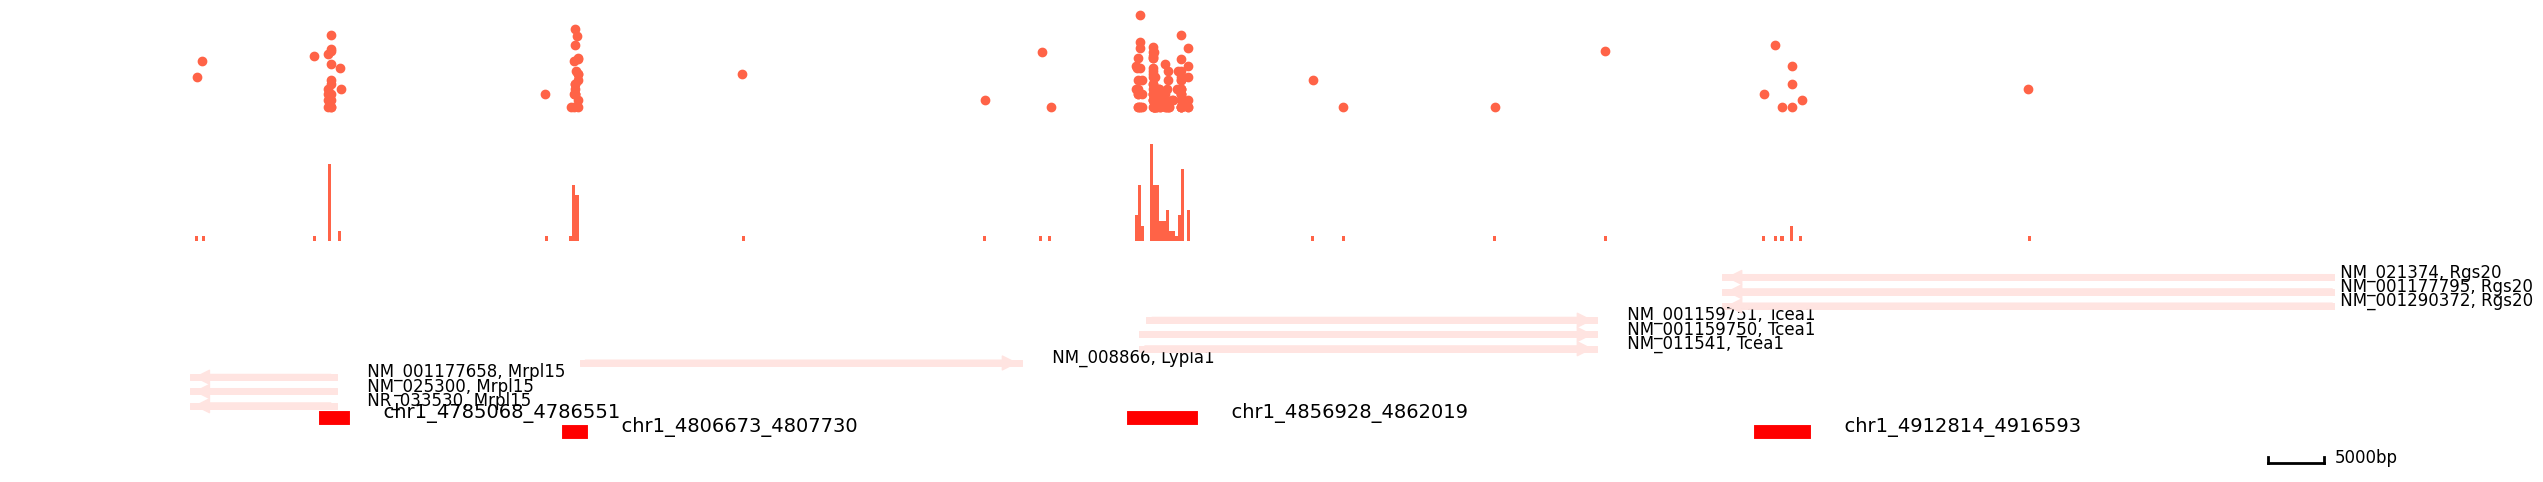

In [7]:
cc.pl.draw_area("chr1",4856929,4863861,100000,peak_data, Brd4, "mm10", 
                figsize = (30,6),peak_line = 2,save = False, example_length = 5000)

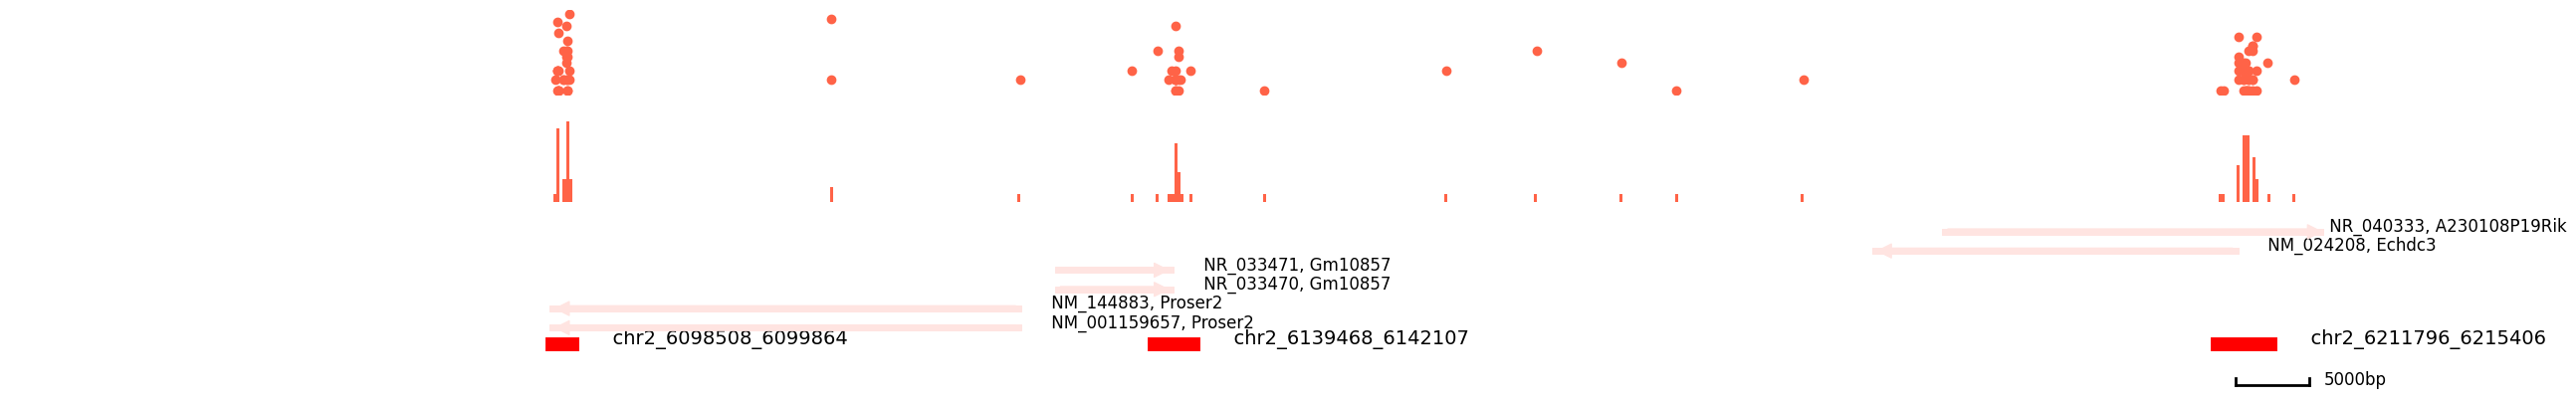

In [8]:
cc.pl.draw_area("chr2",6136575,6144043,75000, peak_data, Brd4, "mm10", 
                figsize = (30,5),peak_line = 1,save = False, example_length = 5000)

We could also visualize our data in [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/) directly. 
Notice that this link only valid for 24hrs, so please rerun it if you want to use it.

In [9]:
qbed = {"Brd4":Brd4}
bed = {"peak":peak_data}
cc.pl.WashU_browser_url(qbed = qbed,bed = bed,genome = 'mm10')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=mm10&hub=https://companion.epigenomegateway.org//task/3f913a36b5f8aa46b7325bdf906c822c/output//datahub.json


We advise to look at the whole chromosome and see the distribution of peaks to make sure everything is going accordingly.

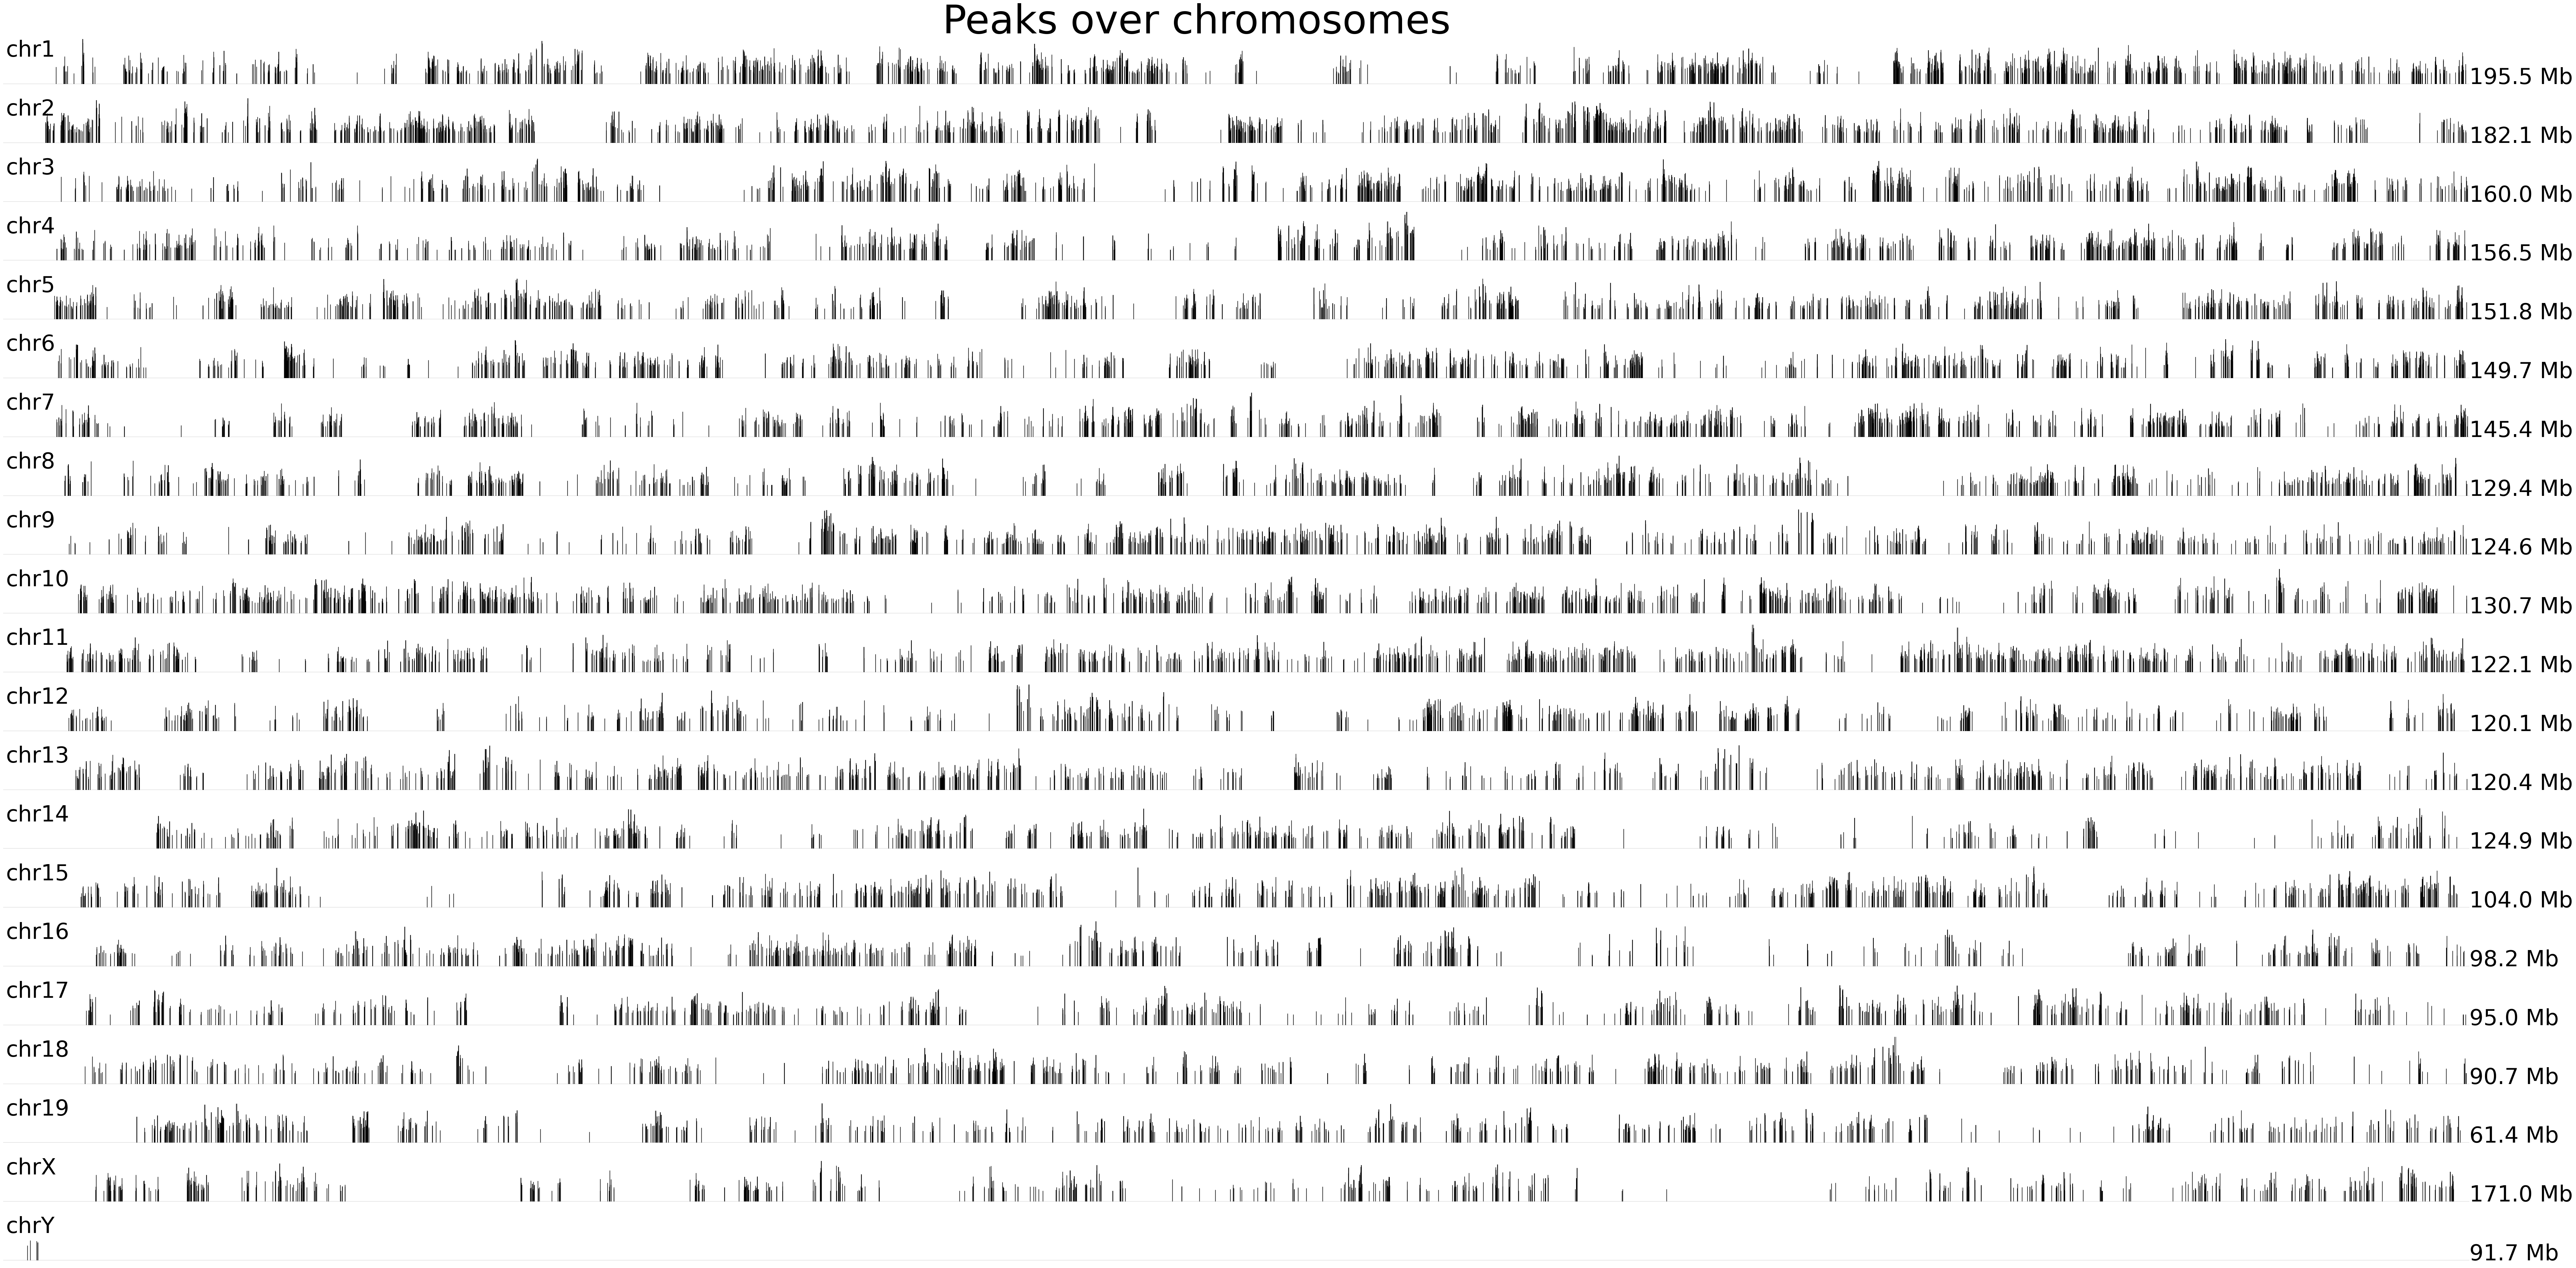

In [10]:
cc.pl.whole_peaks(peak_data, reference = "mm10", linewidth = 1)

Here, we first combine the data and then call peaks together. Although not recommended, you could also try calling peaks seperately and then merge the peaks by using [pybedtools](https://daler.github.io/pybedtools/). Below are the codes:

```python
import pybedtools
peak_data1 = cc.pp.callpeaks(Female_Brd4,  method = "CCcaller", reference = "mm10", pvalue_cutoffbg = 0.1, maxbetween = 2000,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = 1000000,  pseudocounts = 0.1, record = True)
peak_data2 = cc.pp.callpeaks(Male_Brd4,  method = "CCcaller", reference = "mm10",  pvalue_cutoffbg = 0.1, maxbetween = 2000,
                  pvalue_cutoffTTAA = 0.001, lam_win_size = 1000000,  pseudocounts = 0.1, record = True)
peak = cc.rd.combine_qbed([peak_data1,peak_data2])
peak = pybedtools.BedTool.from_dataframe(peak).merge().to_dataframe() 
peak_data = peak.rename(columns={"chrom":"Chr", "start":"Start", "end":"End"})
```

In the next step, we find out the closest genes for each peak to annotate using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [11]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data,peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue,pvalue_adj,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chr1,4196775,4198714,16,12,0.142389,0.000000e+00,0.000000e+00,NM_001195662,Rp1,NM_011283,Rp1
1,chr1,4785068,4786551,17,15,0.572576,0.000000e+00,0.000000e+00,NR_033530,Mrpl15,NM_008866,Lypla1
2,chr1,4806673,4807730,21,12,0.477937,0.000000e+00,0.000000e+00,NM_008866,Lypla1,NR_033530,Mrpl15
3,chr1,4856928,4862019,104,44,1.490080,0.000000e+00,0.000000e+00,NM_011541,Tcea1,NM_008866,Lypla1
4,chr1,4912814,4916593,7,22,0.791756,1.900897e-06,1.024407e-04,NM_001290372,Rgs20,NM_011541,Tcea1
...,...,...,...,...,...,...,...,...,...,...,...,...
25996,chrX,169936677,169937745,7,8,1.189526,3.479200e-05,1.673495e-03,NM_010797,Mid1,NR_029457,G530011O06Rik
25997,chrY,897430,899700,11,24,0.528165,6.046275e-13,5.162843e-11,NM_011419,Kdm5d,NM_011667,Uba1y
25998,chrY,1009018,1011799,27,25,0.489073,0.000000e+00,0.000000e+00,NM_012011,Eif2s3y,NR_027507,Tspy-ps
25999,chrY,1243715,1246316,24,29,0.504932,0.000000e+00,0.000000e+00,NM_009484,Uty,NM_012008,Ddx3y


Use qbed data, peak data, and barcode data to make a cell by peak [Anndata](https://anndata.readthedocs.io/en/latest/) object.

In [12]:
adata_cc = cc.pp.make_Anndata(Brd4, peak_annotation, ["Female_Brd4","Male_Brd4"], key = 'group')
adata_cc

100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


AnnData object with n_obs × n_vars = 2 × 26001
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

In [13]:
adata_cc.obs

""
Index
Female_Brd4
Male_Brd4


In [14]:
adata_cc

AnnData object with n_obs × n_vars = 2 × 26001
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

In [15]:
adata_cc = cc.tl.liftover(adata_cc)
adata_cc

100%|██████████| 26001/26001 [05:53<00:00, 73.50it/s] 


AnnData object with n_obs × n_vars = 2 × 26001
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'Chr_liftover', 'Start_liftover', 'End_liftover'

Differential peak analysis will find out the significant binding for each group. In this example, we use the *Fisher's exact test* to find out.

In [16]:
cc.tl.rank_peak_groups(adata_cc,"Index",method = 'fisher_exact',key_added = 'fisher_exact')

100%|██████████| 2/2 [02:04<00:00, 62.49s/it]


Plot the results for differential peak analysis.

```python
cc.tl.rank_peak_groups(adata_cc,"Index",method = 'fisher_exact',key_added = 'fisher_exact',rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact',rankby = 'logfoldchanges')

```

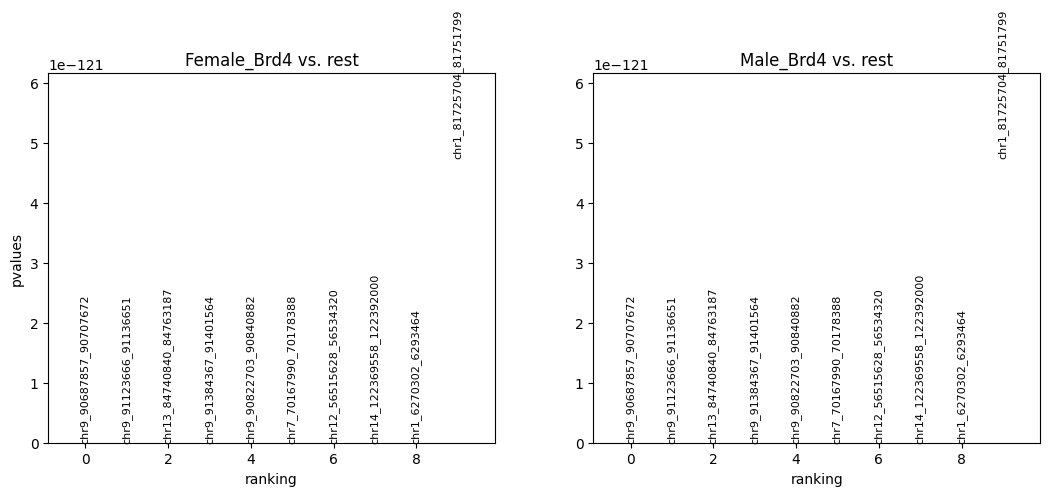

In [17]:
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact', rankby = 'pvalues')

Then, we take a look at the genome for the highly differentiated peaks. The colored ones are the insertions for the specific cluster and the grey ones are the total insertions for the whole dataset. 

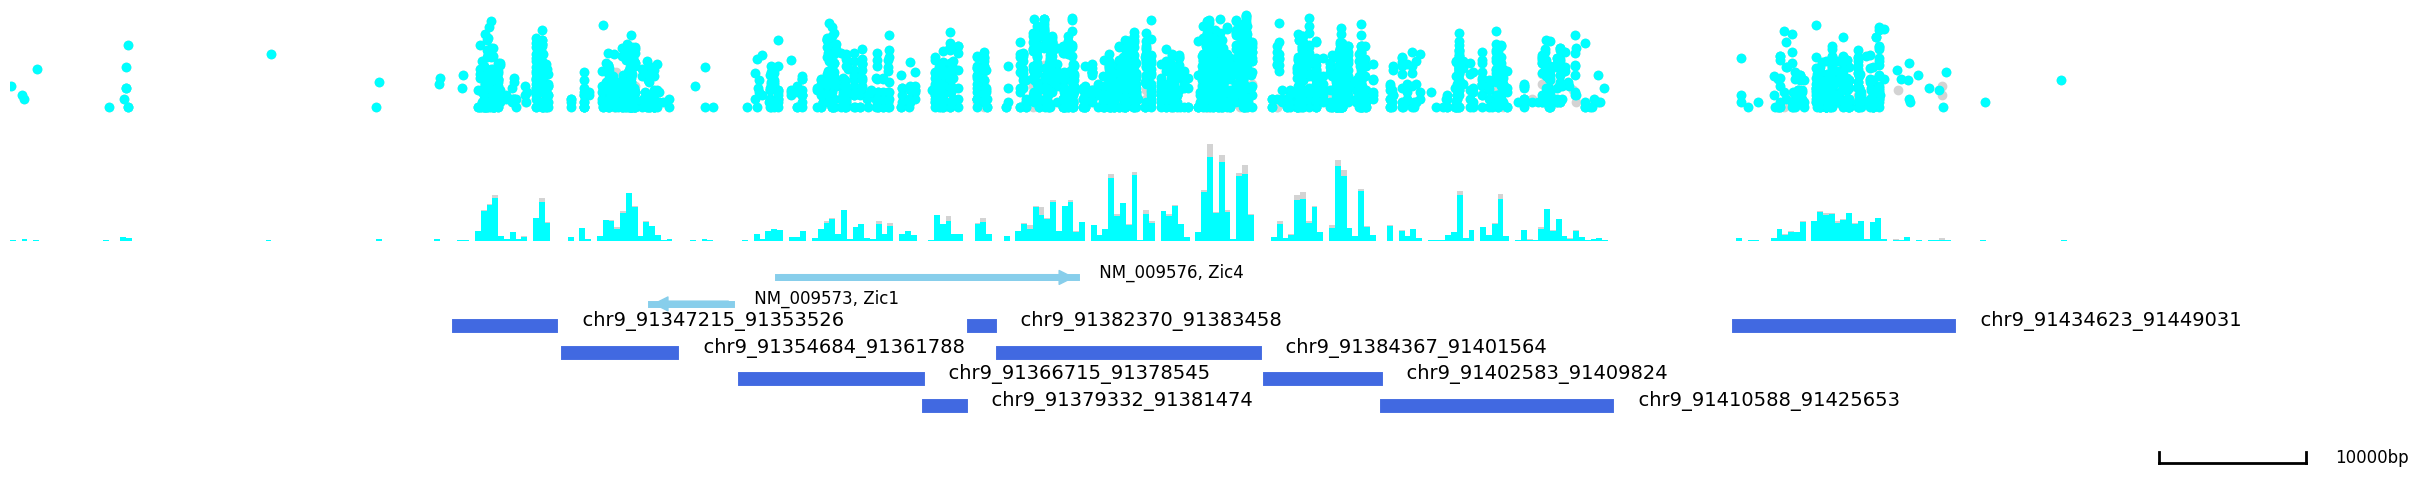

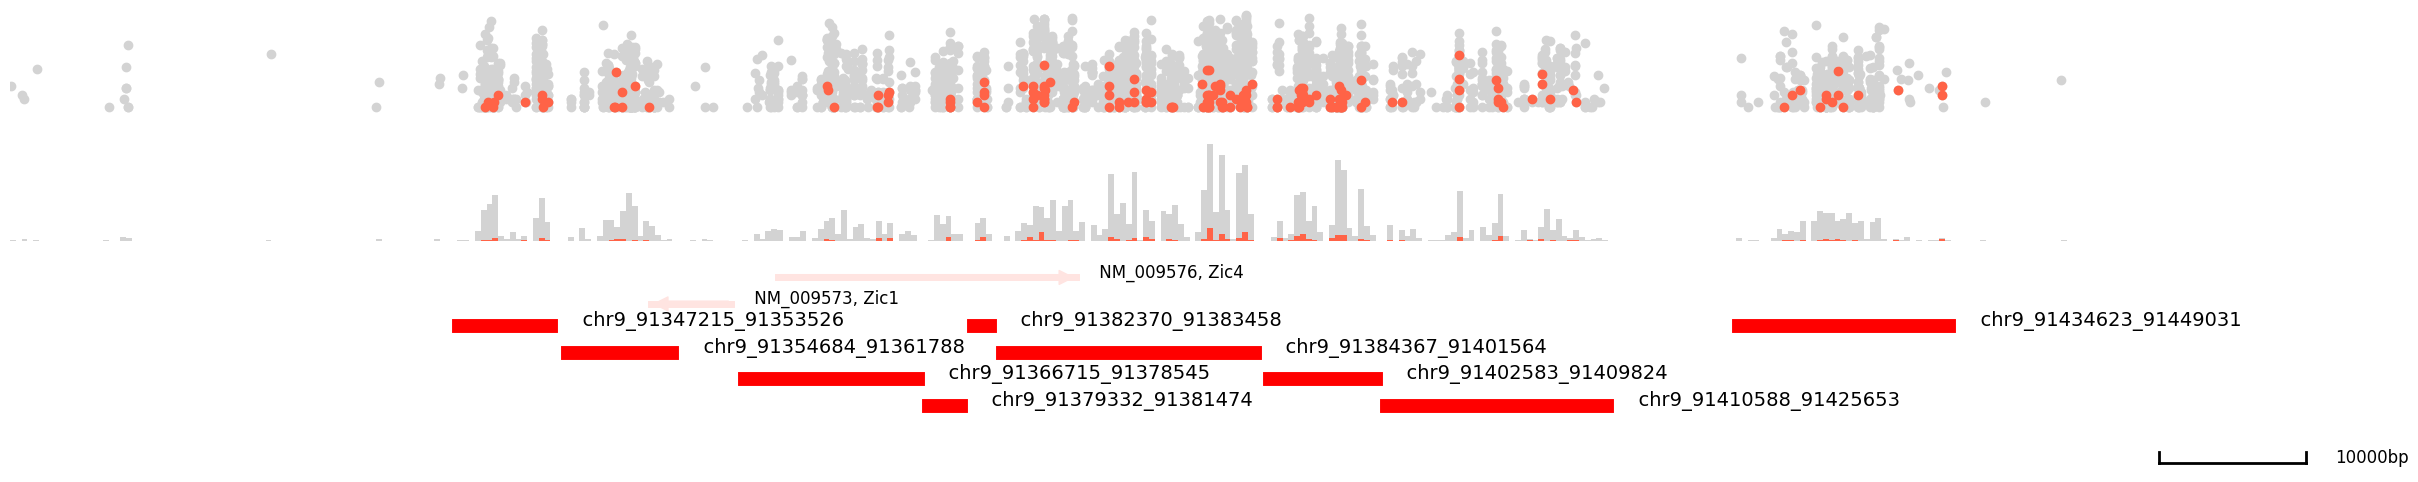

In [18]:
cc.pl.draw_area("chr9",91366534,91425373,50000,peak_data,Brd4,"mm10",adata = adata_cc, 
                name = "Female_Brd4",key = "Index",insertionkey = "group", bins = 400, figsize = (30,6), peak_line = 4,color = "blue")
cc.pl.draw_area("chr9",91366534,91425373,50000,peak_data, Brd4,"mm10",adata = adata_cc, 
                name = "Male_Brd4",key = "Index", insertionkey = "group",bins = 400, figsize = (30,6),peak_line = 4)

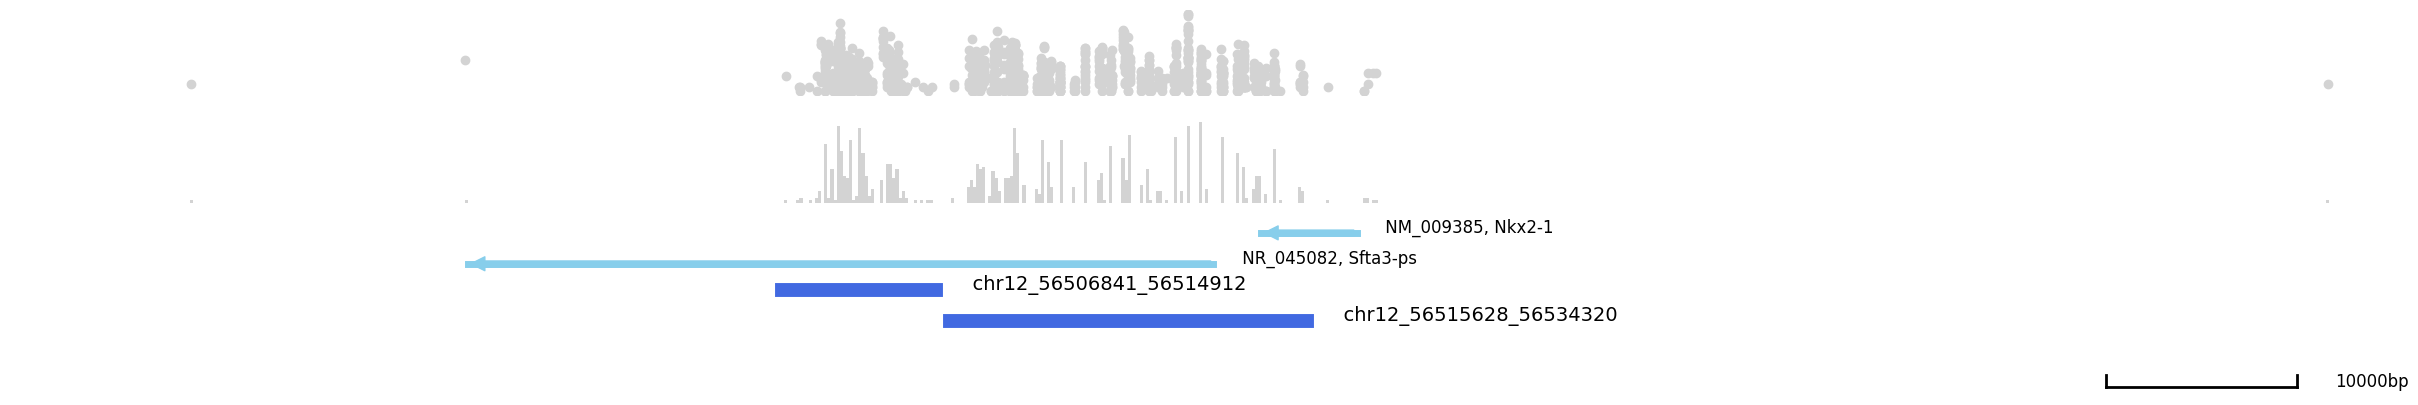

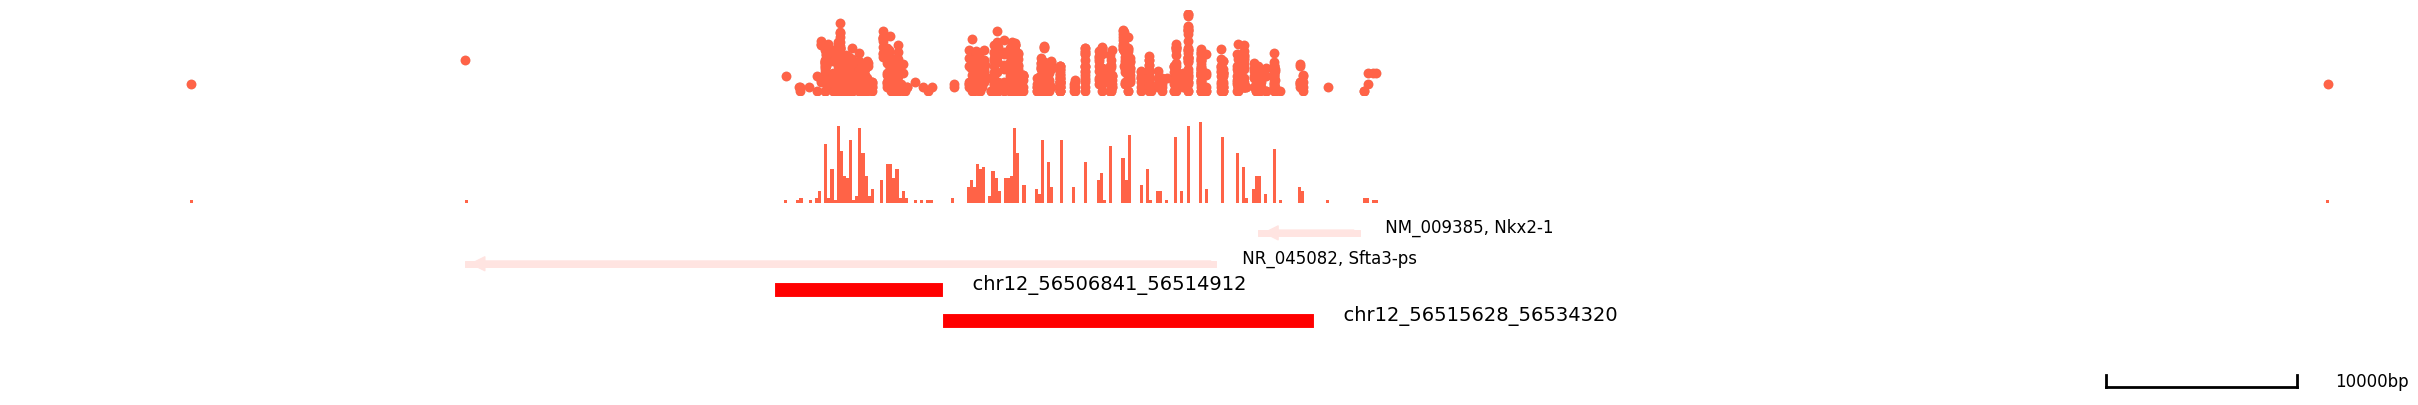

In [19]:
cc.pl.draw_area("chr12",56516453,56538107,50000,peak_data,Brd4,"mm10",adata = adata_cc, 
                name = "Female_Brd4",key = "Index",insertionkey = "group", figsize = (30,5),peak_line = 2,color = "blue")
cc.pl.draw_area("chr12",56516453,56538107,50000,peak_data, Brd4,"mm10",adata = adata_cc, 
                name = "Male_Brd4",key = "Index", insertionkey = "group", figsize = (30,5),peak_line = 2)

Plot the volcano plot for differential binding sites. labelright and labellest are the location points of the labels.

/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_volcano.py:61: RuntimeWarning: divide by zero encountered in log10
  pva = -np.log10(np.array(adata_cc.uns[name]["pvalues"].tolist())[:, 1])


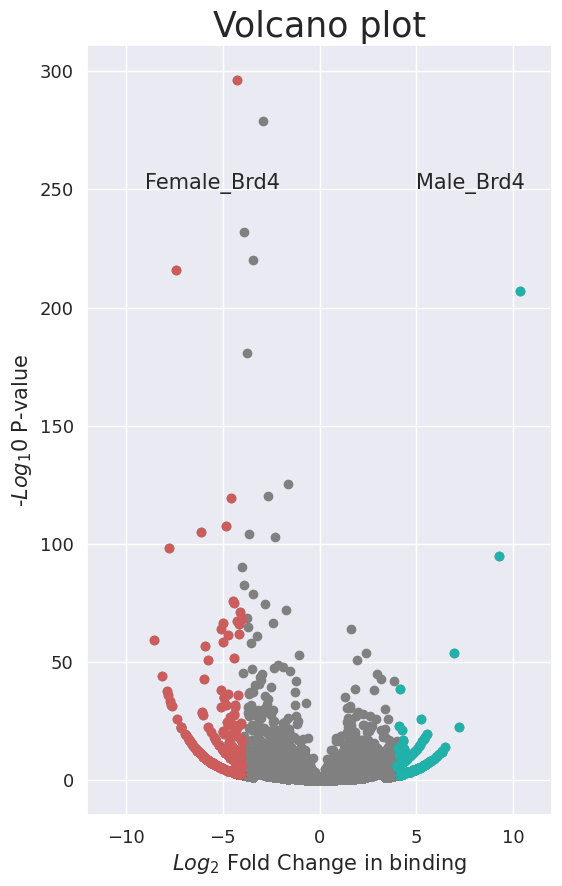

In [20]:
cc.pl.volcano_plot(adata_cc,figsize = (6,10),labelright = (5,250),labelleft = (-9,250))

Call motifs for both female and male binded peaks separately to find out potential motif binding difference.

In [21]:
cc.tl.call_motif(peaks_frame=cc.tl.rank_peak_groups_df(adata_cc,key = 'fisher_exact',pval_cutoff = 0.01,logfc_min = 3, group = ['Female_Brd4'])["names"].str.split("_", expand=True),
                 reference ="mm10",save_homer = "Homer/GBM_female", 
                 homer_path = "/ref/rmlab/software/homer/bin", num_cores=8)
cc.tl.call_motif(peaks_frame=cc.tl.rank_peak_groups_df(adata_cc,key = 'fisher_exact',pval_cutoff = 0.01,logfc_min = 3, group = ['Male_Brd4'])["names"].str.split("_", expand=True),
                 reference ="mm10",save_homer = "Homer/GBM_male", 
                 homer_path = "/ref/rmlab/software/homer/bin", num_cores=8)

There is no save_name, it will save to temp_Homer_trial.bed and then delete.



	Position file = temp_Homer_trial.bed
	Genome = mm10
	Output Directory = Homer/GBM_female
	Fragment size set to 1000
	Using 8 CPUs
	Will not run homer for de novo motifs
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 1055
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 1055
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 1000 bp fragments found.

	Extracting sequences from directory: /ref/rmlab/software/homer/.//data/genomes/mm10//
	Extracting 99 sequences from chr1
	Extracting 97 sequences from chr2
	Extracting 66 sequences from chr3
	Extracting 41 sequences from chr4
	Extracting 68 sequences from chr5
	Extracting 68 sequences from chr6
	Extracting 63 sequences from chr7


Finished!
There is no save_name, it will save to temp_Homer_trial.bed and then delete.


	Peak/BED file conversion summary:
		BED/Header formatted lines: 603
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 603
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 1000 bp fragments found.

	Extracting sequences from directory: /ref/rmlab/software/homer/.//data/genomes/mm10//
	Extracting 37 sequences from chr1
	Extracting 42 sequences from chr2
	Extracting 34 sequences from chr3
	Extracting 20 sequences from chr4
	Extracting 28 sequences from chr5
	Extracting 35 sequences from chr6
	Extracting 20 sequences from chr7
	Extracting 27 sequences from chr8
	Extracting 21 sequences from chr9
	Extracting 56 sequences from chr10
	Extracting 40 sequences from chr11
	Extracting 27 sequences from chr12
	Extracting 23 sequences from chr13
	Extracting 36 sequenc

Finished!


	Skipping...
	Job finished - if results look good, please send beer to ..

	Cleaning up tmp files...



Find out motifs in male but not in female.

In [22]:
cc.tl.compare_motif("Homer/GBM_male","Homer/GBM_female")

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 603),% of Target Sequences with Motif,# of Background Sequences with Motif(of 48688),% of Background Sequences with Motif
7,Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)...,HTGCTGAGTCAT,1.000000e-10,-24.620,0.0000,39.0,6.47%,883.3,1.81%
8,NF-E2(bZIP)/K562-NFE2-ChIP-Seq(GSE31477)/Homer,GATGACTCAGCA,1.000000e-09,-22.110,0.0000,42.0,6.97%,1096.6,2.25%
9,Bach1(bZIP)/K562-Bach1-ChIP-Seq(GSE31477)/Homer,AWWNTGCTGAGTCAT,1.000000e-08,-20.210,0.0000,40.0,6.63%,1078.4,2.22%
10,MafK(bZIP)/C2C12-MafK-ChIP-Seq(GSE36030)/Homer,GCTGASTCAGCA,1.000000e-06,-15.640,0.0000,100.0,16.58%,4771.1,9.80%
13,Sox3(HMG)/NPC-Sox3-ChIP-Seq(GSE33059)/Homer,CCWTTGTY,1.000000e-04,-9.357,0.0016,447.0,74.13%,32611.9,66.99%
17,TATA-Box(TBP)/Promoter/Homer,CCTTTTAWAGSC,1.000000e-03,-7.437,0.0086,393.0,65.17%,28545.8,58.64%
18,Lhx2(Homeobox)/HFSC-Lhx2-ChIP-Seq(GSE48068)/Homer,TAATTAGN,1.000000e-02,-6.612,0.0187,352.0,58.37%,25413.0,52.20%
19,Sox10(HMG)/SciaticNerve-Sox3-ChIP-Seq(GSE35132...,CCWTTGTYYB,1.000000e-02,-6.567,0.0187,418.0,69.32%,30884.9,63.44%
21,Sox2(HMG)/mES-Sox2-ChIP-Seq(GSE11431)/Homer,BCCATTGTTC,1.000000e-02,-6.140,0.0259,279.0,46.27%,19690.1,40.45%
22,Sox4(HMG)/proB-Sox4-ChIP-Seq(GSE50066)/Homer,YCTTTGTTCC,1.000000e-02,-5.844,0.0332,258.0,42.79%,18123.6,37.23%


Find out motifs in female but not in male.

In [23]:
cc.tl.compare_motif("Homer/GBM_female","Homer/GBM_male")

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 1055),% of Target Sequences with Motif,# of Background Sequences with Motif(of 48559),% of Background Sequences with Motif
0,ISRE(IRF)/ThioMac-LPS-Expression(GSE23622)/Homer,AGTTTCASTTTC,1.000000e-18,-42.250,0.0000,106.0,10.05%,1840.4,3.79%
1,Chop(bZIP)/MEF-Chop-ChIP-Seq(GSE35681)/Homer,ATTGCATCAT,1.000000e-17,-40.110,0.0000,201.0,19.05%,4933.5,10.17%
2,Atf4(bZIP)/MEF-Atf4-ChIP-Seq(GSE35681)/Homer,MTGATGCAAT,1.000000e-16,-38.380,0.0000,234.0,22.18%,6191.2,12.76%
7,IRF2(IRF)/Erythroblas-IRF2-ChIP-Seq(GSE36985)/...,GAAASYGAAASY,1.000000e-12,-29.440,0.0000,122.0,11.56%,2750.3,5.67%
10,IRF1(IRF)/PBMC-IRF1-ChIP-Seq(GSE43036)/Homer,GAAAGTGAAAGT,1.000000e-10,-23.580,0.0000,155.0,14.69%,4169.5,8.59%
11,Rbpj1(?)/Panc1-Rbpj1-ChIP-Seq(GSE47459)/Homer,HTTTCCCASG,1.000000e-08,-19.220,0.0000,622.0,58.96%,24301.2,50.08%
12,GABPA(ETS)/Jurkat-GABPa-ChIP-Seq(GSE17954)/Homer,RACCGGAAGT,1.000000e-06,-15.310,0.0000,394.0,37.35%,14574.2,30.04%
13,CEBP:AP1(bZIP)/ThioMac-CEBPb-ChIP-Seq(GSE21512...,DRTGTTGCAA,1.000000e-06,-14.690,0.0000,433.0,41.04%,16360.4,33.72%
14,NF1-halfsite(CTF)/LNCaP-NF1-ChIP-Seq(Unpublish...,YTGCCAAG,1.000000e-05,-13.350,0.0000,610.0,57.82%,24560.1,50.62%
15,ETS1(ETS)/Jurkat-ETS1-ChIP-Seq(GSE17954)/Homer,ACAGGAAGTG,1.000000e-05,-13.130,0.0000,465.0,44.08%,17999.4,37.10%


Read bulk RNA-seq data. Note that this RNA-seq data is normalized by [RPKM](https://wiki.arrayserver.com/wiki/index.php?title=RPKM).

In [24]:
rna =  cc.datasets.mouse_brd4_data(data="RNA")
rna

,sample.f6_dmso_3,sample.f6_dmso_2,sample.f6_dmso_1,sample.m6_dmso_3,sample.m6_dmso_2,sample.m6_dmso_1
mt-Tf,0.000000,0.639272,0.000000,1.156308,0.000000,0.687531
mt-Rnr1,127.907281,184.396768,172.544723,130.417054,192.566581,114.212201
mt-Tv,0.000000,0.000000,1.761150,0.000000,0.510777,0.000000
mt-Rnr2,247.267306,527.855824,324.345998,675.031187,684.376279,418.345603
mt-Tl1,44.418710,117.660098,70.481211,167.217607,115.129081,127.789076
...,...,...,...,...,...,...
Gm16897,0.281553,0.349020,0.463442,0.078913,0.070742,0.112610
A330023F24Rik,0.118678,0.055749,0.058441,0.029411,0.018833,0.049965
Cd46,0.127930,0.095151,0.075997,0.061467,0.055103,0.087715
Cr1l,9.993119,14.027801,13.717564,13.586101,13.240219,11.089902


Plot the heatmap for calling cards data and gene expression data. 

The top lines are the relative binding expression for the two groups. The bottom lines are the gene expressions of the top two nearest genes; each gene shown separately. 

We can see a relationship between bindings and gene expression. Bindings tend to have positive effects for gene expression and have stronger effects for the nearest gene than the second nearest gene.

Please make sure that the samples in adata_cc and rna are in the same order.
['Female_Brd4', 'Male_Brd4']
['Ref gene1 Female1', 'Ref gene1 Female2', 'Ref gene1 Female3', 'Ref gene1 Male1', 'Ref gene1 Male2', 'Ref gene1 Male3']
['Ref gene2 Female1', 'Ref gene2 Female2', 'Ref gene2 Female3', 'Ref gene2 Male1', 'Ref gene2 Male2', 'Ref gene2 Male3']


/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_heatmap_ccrna.py:179: RuntimeWarning: invalid value encountered in divide
  data[groupnumber:secondnum, :]
/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_heatmap_ccrna.py:181: RuntimeWarning: invalid value encountered in divide
  data[secondnum:, :]


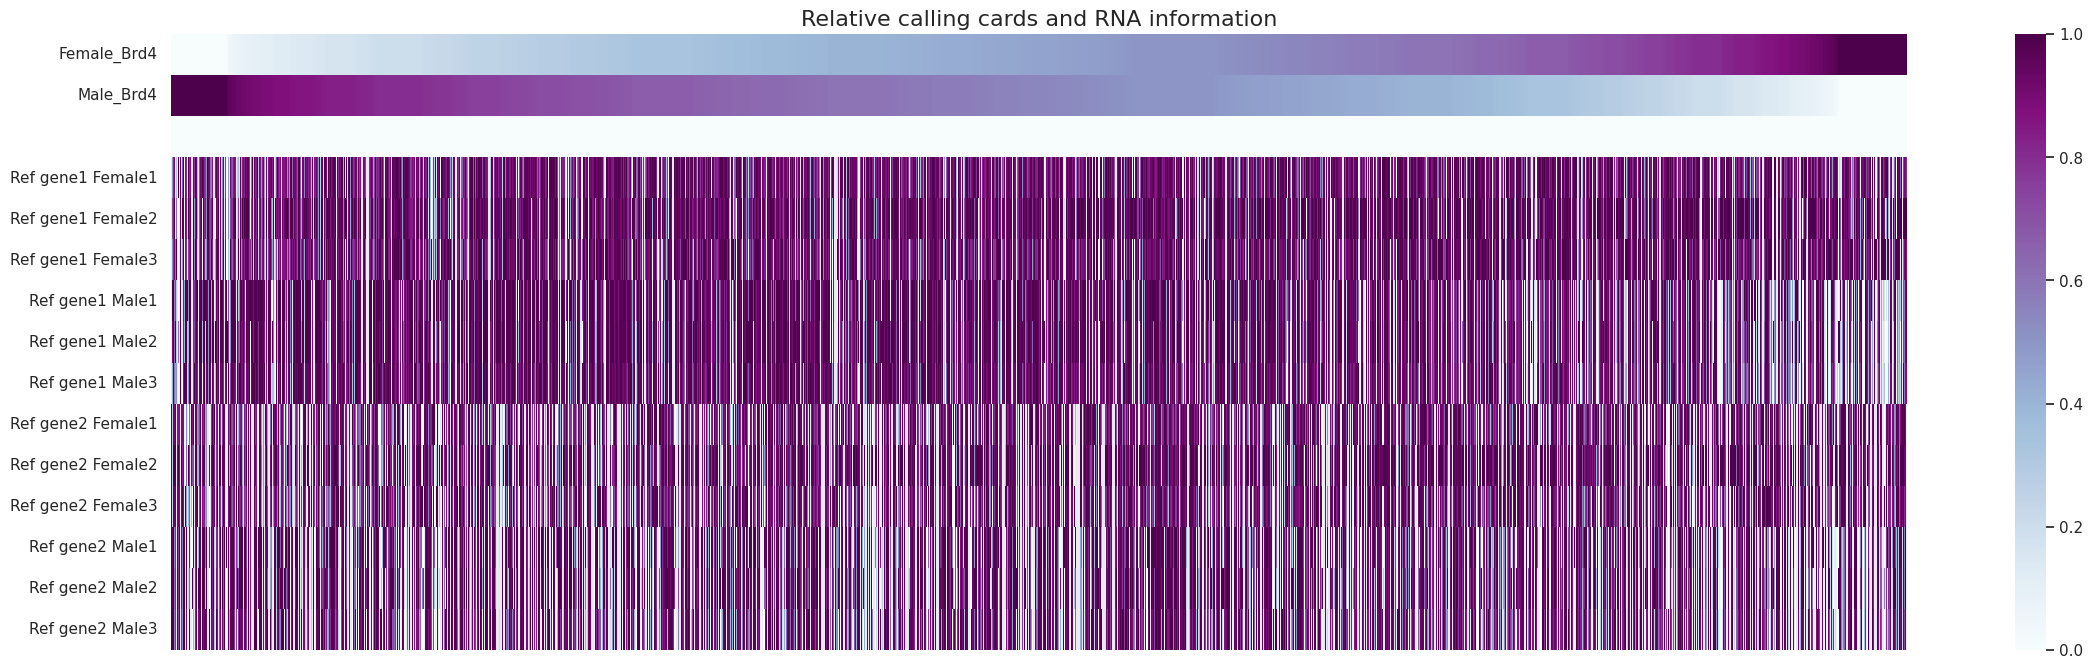

In [25]:
cc.pl.heatmap(adata_cc,rna, rnalabels = ["Female1", "Female2", "Female3","Male1", "Male2","Male3"])

Find out the co-differential peak-gene pairs. Look into all the differential peaks and then see if the annotated genes are also significantly expressed. We can set the pvalue and score/log foldchange cutoff easily.


In [26]:
result = cc.tl.pair_peak_gene_bulk(adata_cc,"https://github.com/The-Mitra-Lab/pycallingcards_data/releases/download/data/deseq_MF.csv",name_cc = 'logfoldchanges',
                                   pvalue_cutoff_cc = 0.001, pvalue_cutoff_rna = 0.001, lfc_cutoff_rna = 5, lfc_cutoff_cc = 5)
result

,Peak,logfoldchanges_peak,Pvalue_peak,Gene,Score_gene,Pvalue_peak
0,chr1_174659622_174662521,5.637326,1.527052e-08,Grem2,-10.401831,1.280025e-67
1,chr1_174917639_174921559,6.193492,2.704002e-12,Grem2,-10.401831,1.280025e-67
2,chr2_93645657_93648162,5.174623,2.357231e-06,Alx4,-10.292504,5.458739e-18
3,chr3_33140350_33142508,5.519550,6.443999e-08,Pex5l,-7.590236,2.351122e-24
4,chr3_126498429_126499612,5.322626,5.586049e-07,Arsj,-6.281259,8.667831e-27
5,chr3_126657669_126660188,-5.382493,5.550749e-07,Arsj,-6.281259,8.667831e-27
6,chr3_132085669_132092999,6.119937,1.468496e-105,Dkk2,-6.916087,9.389039e-178
7,chr3_132093815_132106295,5.071474,9.439104e-65,Dkk2,-6.916087,9.389039e-178
8,chr3_141699368_141702608,6.060401,2.385400e-29,Bmpr1b,-5.570116,6.893076e-40
9,chr4_68535893_68538867,5.167475,1.969706e-15,Brinp1,-7.758307,5.384595e-10


Plot the above results.

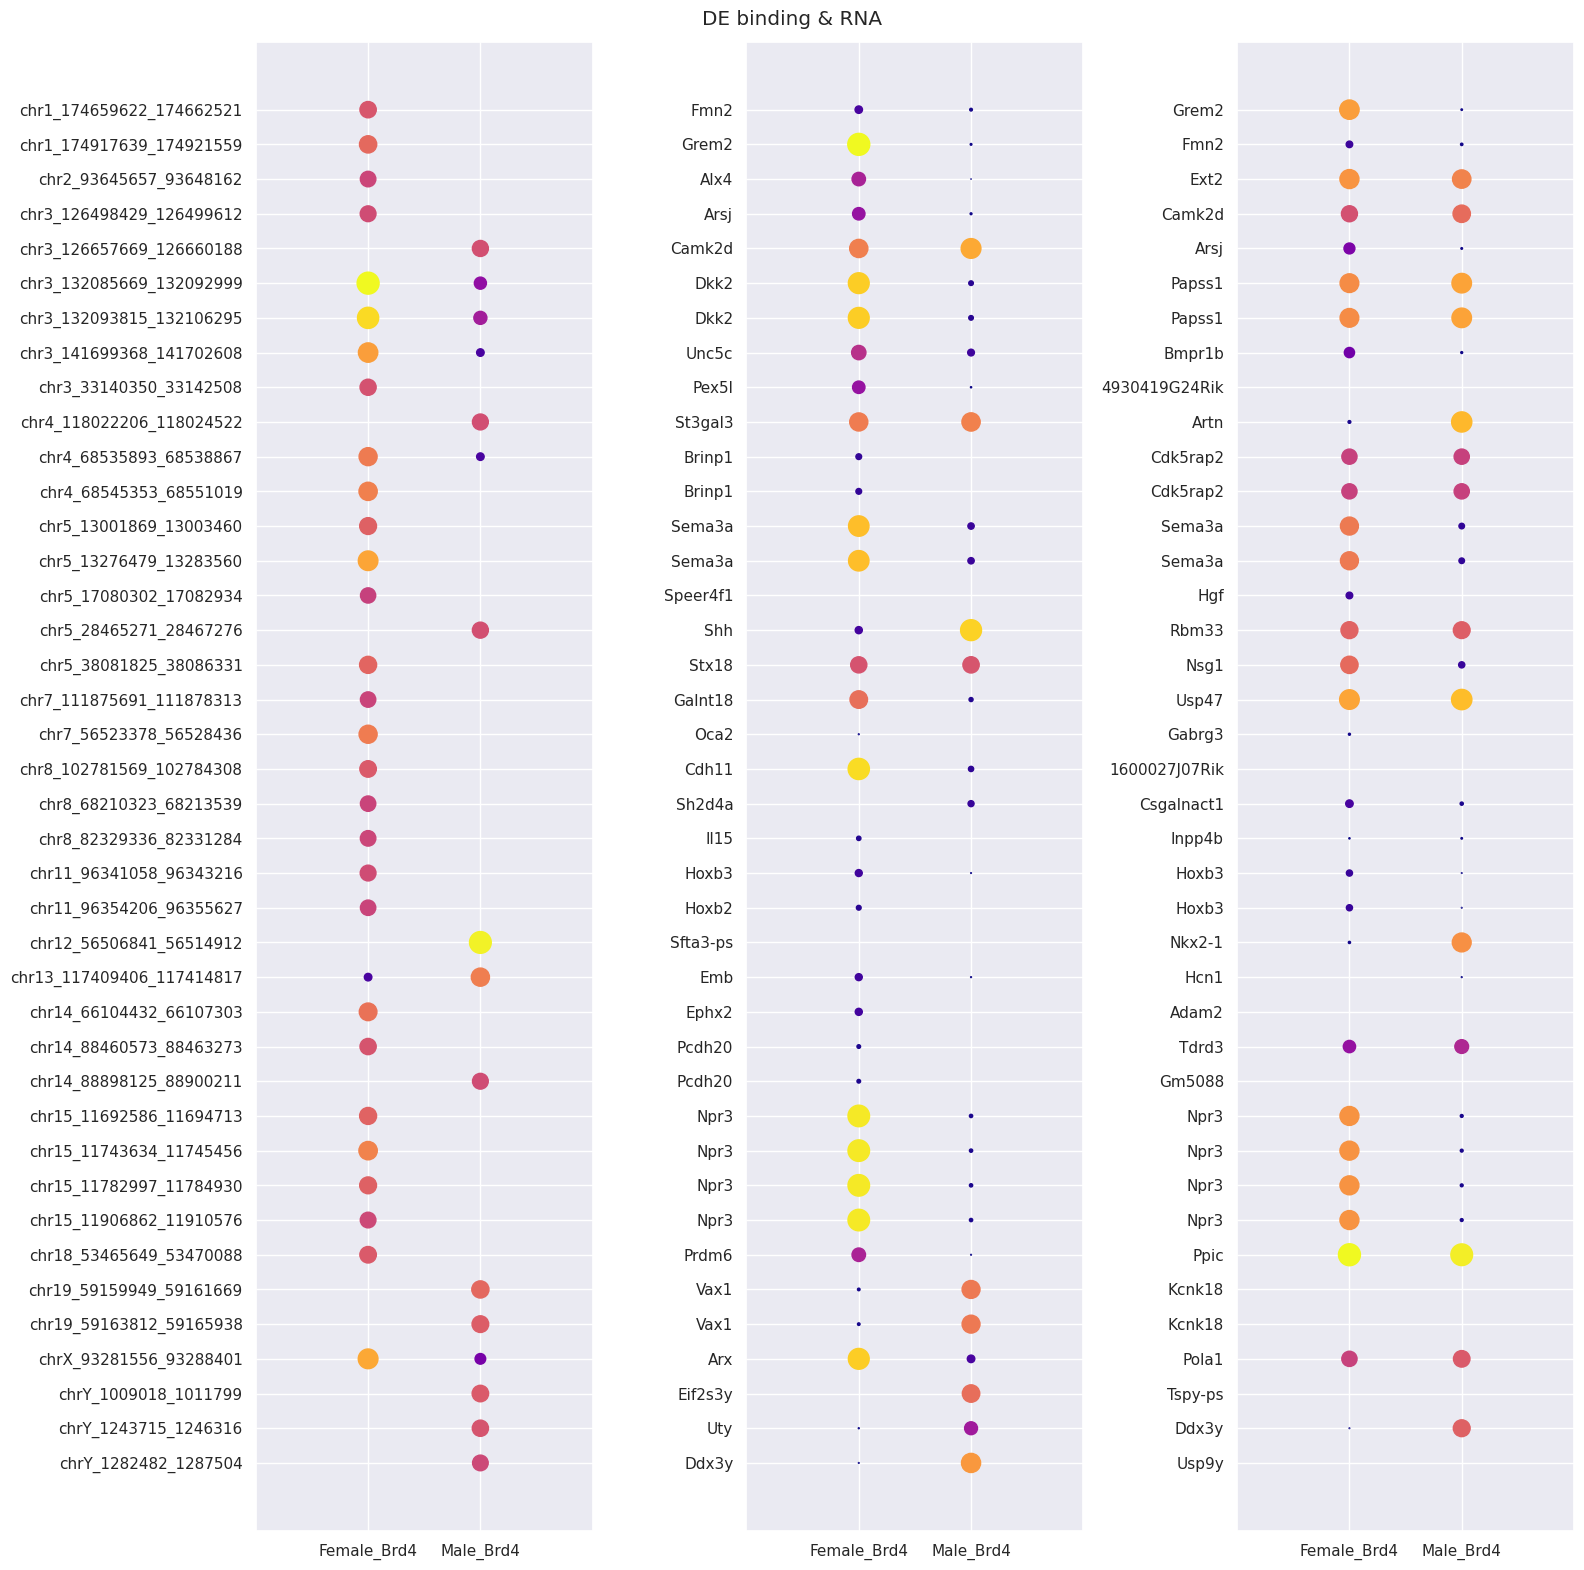

In [27]:
cc.pl.dotplot_bulk(adata_cc,rna,selected_list = list(np.unique(np.array(result["Peak"]))), num_list = [3,3], cmap = 'plasma', figsize=(16, 16), sort_by_chrom = True, topspace=0.96)

We can see from the results that all bindings are differential and at least one of the nearest genes is differential. For most of the situations, bindings have a positive influence on gene expression. We could make many hypotheses to test.

Now, we can test these hypotheses in the mouse genome. However, we could try to map the binding sites and gene to the human genome. We use [liftover](https://genome.ucsc.edu/cgi-bin/hgLiftOver) to get the resuls.

In [28]:
result = cc.tl.result_mapping(result)
result

Start mapping the peaks to the new genome.


100%|██████████| 49/49 [00:00<00:00, 67.23it/s] 


Start finding location of genes in the new genome.


100%|██████████| 49/49 [00:00<00:00, 230.33it/s]


,Peak,logfoldchanges_peak,Pvalue_peak,Gene,Score_gene,Pvalue_peak,Chr_liftover,Start_liftover,End_liftover,Chr_hg38,Start_hg38,End_hg38
0,chr1_174659622_174662521,5.637326,1.527052e-08,Grem2,-10.401831,1.280025e-67,chr1,240280756,240283835,chr1,240489572,240612162
1,chr1_174917639_174921559,6.193492,2.704002e-12,Grem2,-10.401831,1.280025e-67,chr1,240608636,240611870,chr1,240489572,240612162
2,chr2_93645657_93648162,5.174623,2.357231e-06,Alx4,-10.292504,5.458739e-18,chr11,44303696,44306415,chr11,44260727,44310166
3,chr3_33140350_33142508,5.519550,6.443999e-08,Pex5l,-7.590236,2.351122e-24,chr3,180033883,180036186,chr3,179794958,180037053
4,chr3_126498429_126499612,5.322626,5.586049e-07,Arsj,-6.281259,8.667831e-27,chr4,113839066,113844568,chr4,113900283,113979722
5,chr3_126657669_126660188,-5.382493,5.550749e-07,Arsj,-6.281259,8.667831e-27,chr4,113683844,113686758,chr4,113900283,113979722
6,chr3_132085669_132092999,6.119937,1.468496e-105,Dkk2,-6.916087,9.389039e-178,chr4,107029387,107035946,chr4,106921801,107036296
7,chr3_132093815_132106295,5.071474,9.439104e-65,Dkk2,-6.916087,9.389039e-178,chr4,107015456,107028826,chr4,106921801,107036296
8,chr3_141699368_141702608,6.060401,2.385400e-29,Bmpr1b,-5.570116,6.893076e-40,chr4,95306647,95309431,chr4,94757976,95158450
9,chr4_68535893_68538867,5.167475,1.969706e-15,Brinp1,-7.758307,5.384595e-10,chr9,118993297,118996641,chr9,119166629,119369461


In [29]:
GWAS_result = cc.tl.GWAS(result)
GWAS_result

,Peak,logfoldchanges_peak,Pvalue_peak,Gene,Score_gene,Pvalue_peak,Chr_liftover,Start_liftover,End_liftover,Chr_hg38,Start_hg38,End_hg38,GWAS
0,chr1_174659622_174662521,5.637326,1.527052e-08,Grem2,-10.401831,1.280025e-67,chr1,240280756,240283835,chr1,240489572,240612162,Coronary heart disease
1,chr1_174917639_174921559,6.193492,2.704002e-12,Grem2,-10.401831,1.280025e-67,chr1,240608636,240611870,chr1,240489572,240612162,
2,chr2_93645657_93648162,5.174623,2.357231e-06,Alx4,-10.292504,5.458739e-18,chr11,44303696,44306415,chr11,44260727,44310166,
3,chr3_33140350_33142508,5.519550,6.443999e-08,Pex5l,-7.590236,2.351122e-24,chr3,180033883,180036186,chr3,179794958,180037053,
4,chr3_126498429_126499612,5.322626,5.586049e-07,Arsj,-6.281259,8.667831e-27,chr4,113839066,113844568,chr4,113900283,113979722,
5,chr3_126657669_126660188,-5.382493,5.550749e-07,Arsj,-6.281259,8.667831e-27,chr4,113683844,113686758,chr4,113900283,113979722,
6,chr3_132085669_132092999,6.119937,1.468496e-105,Dkk2,-6.916087,9.389039e-178,chr4,107029387,107035946,chr4,106921801,107036296,
7,chr3_132093815_132106295,5.071474,9.439104e-65,Dkk2,-6.916087,9.389039e-178,chr4,107015456,107028826,chr4,106921801,107036296,
8,chr3_141699368_141702608,6.060401,2.385400e-29,Bmpr1b,-5.570116,6.893076e-40,chr4,95306647,95309431,chr4,94757976,95158450,
9,chr4_68535893_68538867,5.167475,1.969706e-15,Brinp1,-7.758307,5.384595e-10,chr9,118993297,118996641,chr9,119166629,119369461,"Gut microbiota (bacterial taxa, hurdle binary ..."


In [30]:
cc.tl.compare_motif("Homer/GBM_male","Homer/GBM_female")

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 603),% of Target Sequences with Motif,# of Background Sequences with Motif(of 48688),% of Background Sequences with Motif
7,Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)...,HTGCTGAGTCAT,1.000000e-10,-24.620,0.0000,39.0,6.47%,883.3,1.81%
8,NF-E2(bZIP)/K562-NFE2-ChIP-Seq(GSE31477)/Homer,GATGACTCAGCA,1.000000e-09,-22.110,0.0000,42.0,6.97%,1096.6,2.25%
9,Bach1(bZIP)/K562-Bach1-ChIP-Seq(GSE31477)/Homer,AWWNTGCTGAGTCAT,1.000000e-08,-20.210,0.0000,40.0,6.63%,1078.4,2.22%
10,MafK(bZIP)/C2C12-MafK-ChIP-Seq(GSE36030)/Homer,GCTGASTCAGCA,1.000000e-06,-15.640,0.0000,100.0,16.58%,4771.1,9.80%
13,Sox3(HMG)/NPC-Sox3-ChIP-Seq(GSE33059)/Homer,CCWTTGTY,1.000000e-04,-9.357,0.0016,447.0,74.13%,32611.9,66.99%
17,TATA-Box(TBP)/Promoter/Homer,CCTTTTAWAGSC,1.000000e-03,-7.437,0.0086,393.0,65.17%,28545.8,58.64%
18,Lhx2(Homeobox)/HFSC-Lhx2-ChIP-Seq(GSE48068)/Homer,TAATTAGN,1.000000e-02,-6.612,0.0187,352.0,58.37%,25413.0,52.20%
19,Sox10(HMG)/SciaticNerve-Sox3-ChIP-Seq(GSE35132...,CCWTTGTYYB,1.000000e-02,-6.567,0.0187,418.0,69.32%,30884.9,63.44%
21,Sox2(HMG)/mES-Sox2-ChIP-Seq(GSE11431)/Homer,BCCATTGTTC,1.000000e-02,-6.140,0.0259,279.0,46.27%,19690.1,40.45%
22,Sox4(HMG)/proB-Sox4-ChIP-Seq(GSE50066)/Homer,YCTTTGTTCC,1.000000e-02,-5.844,0.0332,258.0,42.79%,18123.6,37.23%


In [31]:
cc.tl.rank_peak_groups_df(adata_cc,key = 'fisher_exact',pval_cutoff = 0.01,logfc_min = 3, group = ['Female_Brd4'])

,names,logfoldchanges,pvalues,pvalues_adj,number,number_rest,total,total_rest
0,chr9_90687857_90707672,3.398907,0.000000e+00,0.000000e+00,1896,189,512566,540342
1,chr9_91123666_91136651,4.234408,6.585089e-297,8.560945e-293,1259,70,512566,540342
2,chr9_91384367_91401564,3.904285,1.660662e-232,1.079472e-228,1044,73,512566,540342
3,chr9_90822703_90840882,3.424547,8.028665e-221,4.175066e-217,1105,108,512566,540342
4,chr7_70167990_70178388,7.384210,9.917210e-217,4.297623e-213,719,4,512566,540342
...,...,...,...,...,...,...,...,...
1050,chr16_33177788_33179531,3.873496,6.478977e-03,3.522791e-02,7,0,512566,540342
1051,chr6_22866620_22867024,3.873496,6.478977e-03,3.522791e-02,7,0,512566,540342
1052,chr10_99465451_99468665,3.873496,6.478977e-03,3.522791e-02,7,0,512566,540342
1053,chr18_52628474_52629769,3.873496,6.478977e-03,3.522791e-02,7,0,512566,540342


In [32]:
GWAS_result

,Peak,logfoldchanges_peak,Pvalue_peak,Gene,Score_gene,Pvalue_peak,Chr_liftover,Start_liftover,End_liftover,Chr_hg38,Start_hg38,End_hg38,GWAS
0,chr1_174659622_174662521,5.637326,1.527052e-08,Grem2,-10.401831,1.280025e-67,chr1,240280756,240283835,chr1,240489572,240612162,Coronary heart disease
1,chr1_174917639_174921559,6.193492,2.704002e-12,Grem2,-10.401831,1.280025e-67,chr1,240608636,240611870,chr1,240489572,240612162,
2,chr2_93645657_93648162,5.174623,2.357231e-06,Alx4,-10.292504,5.458739e-18,chr11,44303696,44306415,chr11,44260727,44310166,
3,chr3_33140350_33142508,5.519550,6.443999e-08,Pex5l,-7.590236,2.351122e-24,chr3,180033883,180036186,chr3,179794958,180037053,
4,chr3_126498429_126499612,5.322626,5.586049e-07,Arsj,-6.281259,8.667831e-27,chr4,113839066,113844568,chr4,113900283,113979722,
5,chr3_126657669_126660188,-5.382493,5.550749e-07,Arsj,-6.281259,8.667831e-27,chr4,113683844,113686758,chr4,113900283,113979722,
6,chr3_132085669_132092999,6.119937,1.468496e-105,Dkk2,-6.916087,9.389039e-178,chr4,107029387,107035946,chr4,106921801,107036296,
7,chr3_132093815_132106295,5.071474,9.439104e-65,Dkk2,-6.916087,9.389039e-178,chr4,107015456,107028826,chr4,106921801,107036296,
8,chr3_141699368_141702608,6.060401,2.385400e-29,Bmpr1b,-5.570116,6.893076e-40,chr4,95306647,95309431,chr4,94757976,95158450,
9,chr4_68535893_68538867,5.167475,1.969706e-15,Brinp1,-7.758307,5.384595e-10,chr9,118993297,118996641,chr9,119166629,119369461,"Gut microbiota (bacterial taxa, hurdle binary ..."


Save the file if needed.

In [33]:
adata_cc.write("Brd4_bindings_bulk.h5ad")